# Comparing Lasso, Ridge, and OLS

To motivate the use of regularization techniques we can run through a quick example of when typical OLS will provide poor predictive (and causal) modeling:

## Example: Teacher Retention 

One topic I've had personal experience with is understanding a causal interpretation of motivators to keep teachers in schools, this analysis was ran over a 10 year panel in Texas public middle schools. 

One issue on the predictive side could "What predictors mattered most for teacher attrition?" Using public data you can access teacher data from over 500 schools in Texas, that is 500 observations of teacher tenure, leave rate, and satisfaction. However Texas educational data is rich in features, over 700 to be exact. There are variables on things like class size, average age, race/demographics of staff/students/teachers, professional development courses, proportion of funds spent on certain classes, textbook age, etc. This means:
$$
n = 300; \\

p = 700; \\

p > n
$$

Using OLS in this example leaves us with 3 outcomes. First, we cut down our variables to an acceptable level to run OLS and hope for successful out of sample prediction, however guessing the importance of variables here is a large task and would potentially leave your clients with a less than acceptable deliverable. Second, you could saturate your model, as in use 300 variables and perfectly explain your model. Lastly, you could attempt __dimension reduction__. 


__Dimension reduction__ in the naive sense would have us building some model $f(x)_{p=1}$, starting with the best model with only $X_1$, i.e. one variable, fitting our model, recording accuracy, then picking two variables, fitting, recording accuracy, and picking the better of the two models tested. You would continue in pairwise competition between models, picking the most accurate (based on your criterion, maybe MSE of the validation set?). In our case it would take $2^{700}$ attempts to find the best model, rather challenging! 

Instead we could practice dimension reduction with LASSO or Ridge regressions, which in the most general sense, is OLS with an added constraint that forces us to pick variables $X_p$ that maximizes predictive power without increasing variance (perfectly explaining our training data) to a harmful level. 

## Coding Example: Comparing 3 models with Boston Housing Data
Below compares all three models with boston housing data

### Set-Up

In [46]:
#Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import Lasso, Ridge, RidgeCV, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


In [47]:
#Load Data
df = pd.read_csv("./Boston.csv")
df = df.iloc[:,1:]

### Features & Response 
Split data into Features ($X$) & Response ($Y$), where our response is ```medv```, the median value of owner-occupied homes (in $1,000s).

Our features range from crime per capita (```crim```) to index values measuring accessibility to highways (```rad```).


In [48]:
Y = df['medv']
X = df.drop(['medv', 'chas', 'zn'], axis=1)
#Normalize X with l2 norm
X_norm = preprocessing.normalize(X)


### Split Data
First lets start with the simplest approach, test-train-split to measure out of sample accuracy. Later on we can automate this process to find the best LASSO & Ridge models to run.

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X_norm, Y, random_state=42, test_size= 0.3)

### Linear Regression
To start lets fit our linear model

In [50]:
ols = LinearRegression()

#fit the model
ols.fit(X_train, y_train)

#predict over validation set 
y_predicted = ols.predict(X_val)

#calculate MSE over validation set 
mse = mean_squared_error(y_predicted, y_val)

print(f"Linear Regression MSE of validation set is: {round(mse, 3)}")

Linear Regression MSE of validation set is: 21.063


Let's grab the coefficients sizes across our features:

In [51]:
#zip will merge feature name and coef value by row index, dict will create a discrete tuple to use
ols_coef = dict(zip(X.columns, np.transpose(ols.coef_)))

#another method to grab coef is via data frame:
ols_coef = pd.DataFrame({'X': X.columns,
                        'val': ols.coef_
                        })




### LASSO
Below is how to set up LASSO in python, this is very similar to our OLS approach

We'll use $\lambda$ value of 0.008.

In [52]:
lasso = Lasso(alpha=.008)
lasso.fit(X_train, y_train)
y_predicted = lasso.predict(X_val)
mse_lasso = mean_squared_error(y_predicted, y_val)
print(f"LASSO MSE of validation set is: {round(mse_lasso, 3)}")

LASSO MSE of validation set is: 33.841


In [53]:
#Grab dataset of values much like OLS
lasso_coef = pd.DataFrame({'X': X.columns,
                        'val': lasso.coef_
                        })

lasso_coef

,X,val
0,crim,-22.716100
1,indus,-0.000000
2,nox,0.000000
3,rm,0.000000
4,age,13.803085
5,dis,-0.000000
6,rad,-0.000000
7,tax,-17.414167
8,ptratio,-0.000000
9,black,2.655779


### Ridge Regression
Lastly, lets do the same as OLS & LASSO and grab the MSE for Ridge to compare

We'll use $\lambda$ value of 0.008.

In [54]:
ridge = Ridge(alpha=.008)
ridge.fit(X_train, y_train)
y_predicted = ridge.predict(X_val)
mse_ridge = mean_squared_error(y_predicted, y_val)
print(f"Ridge MSE of validation set is: {round(mse_ridge, 3)}")

Ridge MSE of validation set is: 30.047


In [55]:
#Grab dataset
ridge_coef = pd.DataFrame({'X': X.columns,
                        'val': ridge.coef_
                        })

### Fast Method: Looping
As you probably noticed we just did the same thing three times, but used different models. Instead of writing so many lines of code we can achieve the same output in a simple loop:

In [56]:
#Create dict to assign df name and model type
model_dict = {'ols_coef':ols,
              'lasso_coef': lasso,
              'ridge_coef': ridge}

#Create empty dataframe to store MSE
mse_df = pd.DataFrame({'model':"",
                       'mse': 0},
                      index=[0,1,2])
list_mse = []

for name, model in model_dict.items():
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_val)
    mse = mean_squared_error(y_predicted, y_val)
    list_mse.append(mse)
    
    
    #Grab dataset of values much like OLS
    name = pd.DataFrame({'X': X.columns,
                            'val': model.coef_
                            })

#Store MSE in dataframe as well 
mse_df = pd.DataFrame({'model':['ols', 'lasso', 'ridge'],
                       'mse': list_mse},
                      index=[0,1,2])


### Plot Differences in MSE, Coefficients 

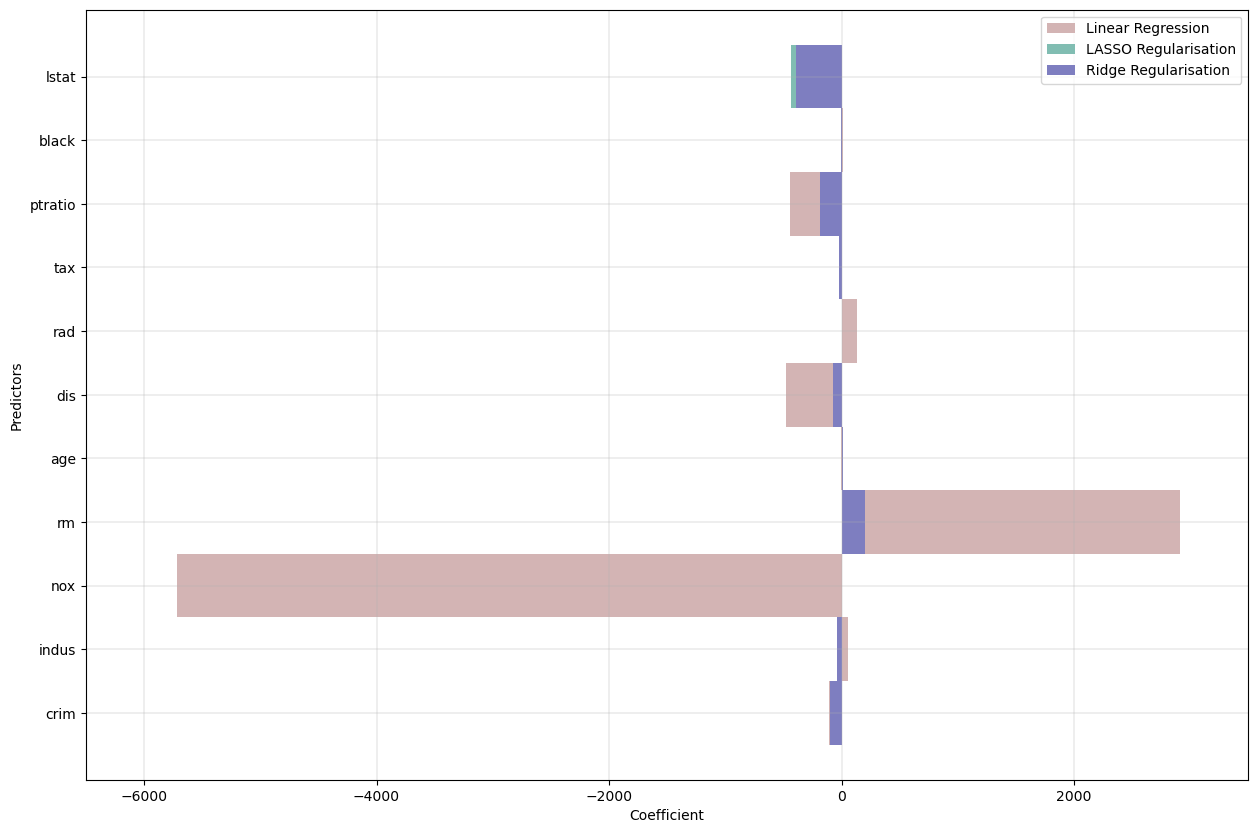

In [83]:
plt.figure(figsize=(15,10))
plt.barh(ols_coef['X'],ols_coef['val'],1,color="#D3B4B4", label="Linear Regression")
plt.barh(lasso_coef['X'],lasso_coef['val'],1,color="#81BDB2",label = "LASSO Regularisation")
plt.barh(ridge_coef['X'],ridge_coef['val'],1 ,color="#7E7EC0", label="Ridge Regularisation")
plt.grid(linewidth=0.3)
plt.xlabel("Coefficient")
plt.ylabel("Predictors")
plt.legend(loc='best')
plt.xlim(-6500,3500)
plt.show()
